## Explanation of `construct_coefficient_matrix` Function Usage

### Input Parameters:
- **`coeffs` (ndarray, list)**: This parameter should be a NumPy array, or nested list containing the coefficient values.
- **`shape` (tuple, optional)**: This optional parameter allows you to specify the shape of the output matrix. If not specified, the shape of `coeffs` is used. This is useful when you need the coefficients expanded to fit a larger or differently shaped field.
- **`axis` (int, optional)**: This optional parameter is used when the coefficients need to be broadcast along a specific axis, typically in cases of staggered grids where fluxes and gradients are defined.

### Output:
- Returns a **`csc_array`**: A sparse matrix in Compressed Sparse Column format with the coefficients placed along its diagonal. This format is efficient for matrices that are mostly zeros, which is typical in applications involving diagonal matrices of coefficients.

### Detailed Parameter Explanation

- **`shape` and Broadcasting**:
  If `shape` is provided, the function first adjusts it if the `axis` parameter is also provided by incrementing the dimension at the specified `axis` index. This adjustment is critical in the context of staggered grids, where the computational grid for fluxes or gradients might extend beyond the typical cell-centered grid dimensions.

  Broadcasting is used to replicate the coefficients according to the specified `shape`. For example, if `coeffs` is singleton in a dimension/axis but `shape` a size larger than 1 along this axis, `coeffs` is tiled accordingly. This means coefficients are repeated over the new dimensions, ensuring that the diagonal matrix expands correctly across all dimensions specified.

- **Staggered Grids**:
  In simulations that use staggered grids, variables like gradients and fluxes are defined at positions neighboring the primary grid points (cells). For example, if you have a grid for concentrations defined at cell centers, the concentration gradient (which might be needed for computing flux) will be defined at cell faces. Thus, if you have `N` cell-centered points along a dimension, you'll have `N+1` face positions along that dimension. This is where the `axis` parameter becomes useful, as it allows the function to adjust the coefficient matrix to align with these staggered positions.

### Understanding Multidimensional Arrays and Nested Square Brackets

In Python and particularly with NumPy, multidimensional arrays can be visualized and represented using nested square brackets. Each level of nesting represents a higher dimension:
- 1D array: `[1, 2, 3]`
- 2D array: `[[1, 2, 3], [4, 5, 6]]`
- 3D array: `[[[1, 2], [3, 4]], [[5, 6], [7, 8]]]`

As an example consider the output of statements:
```
print(np.array([1,2,3]).shape)
print(np.array([[1,2,3]]).shape)
print(np.array([[[1,2,3]]]).shape)
print(np.array([[[1],[2],[3]]]).shape)
print(np.array([[[1]],[[2]],[[3]]]).shape)
```

When working with functions like `construct_coefficient_matrix`, understanding these representations helps in conceptualizing how data is structured and manipulated, especially when broadcasting or tiling operations are involved.

### Further Reading on Broadcasting

For a more thorough understanding of broadcasting, which is a powerful method of extending smaller arrays across larger arrays without making full memory copies, you can refer to the official NumPy documentation on broadcasting here: [Understanding NumPy Broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html)

This function is particularly useful in computational modeling where you often deal with matrix operations on large, sparsely populated matrices, and understanding these subtleties can significantly enhance the efficiency and correctness of your simulations.

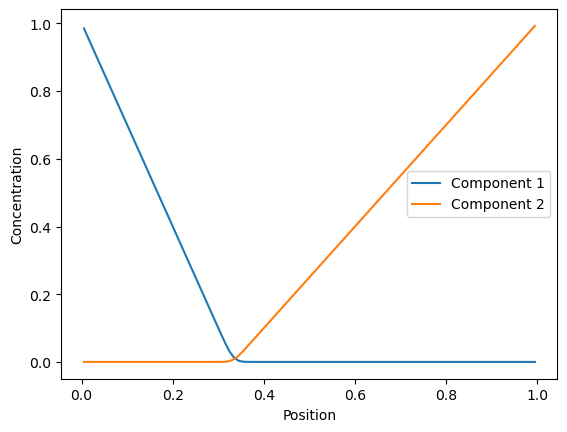

In [1]:
# Example:
import math
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pymrm as mrm

# Define the reaction function
def reaction(c, k):
    f = np.zeros_like(c)
    r = k * c[:, 0] * c[:, 1]
    f[:, 0] = -r
    f[:, 1] = -r
    return f

# Simulation parameters
num_c = 2
num_x = 100
L = 1
c = np.zeros((num_x, num_c))
D = [[1.0, 2.0]] # diffusion coefficient per species
#D = np.linspace(1,0.1,num_x+1).reshape((-1,1)) # position dependent diffusion coefficient
k = 1e6
# Boundary conditions setup
bc = {'a': [0, 0], 'b': [1, 1], 'd':[ [[1, 0]], [[0, 1]]]}

# Grid setup
x_f = np.linspace(0, L, num_x+1)
x_c = 0.5*(x_f[:-1] + x_f[1:])

# Construct gradient and divergence matrices
Grad, grad_bc = mrm.construct_grad(c.shape, x_f, x_c , bc, axis = 0)
D_matrix = mrm.construct_coefficient_matrix(D, c.shape, axis = 0)
Div = mrm.construct_div(c.shape, x_f, nu=0, axis=0)
Flux = -D_matrix @ Grad
flux_bc = -D_matrix @ grad_bc

# Displacement Jacobian
Jac_diff = Div @ (Flux)
jac_diff_bc = Div @ (flux_bc)

def counter_diffusion(c):
    f_react, Jac_react = mrm.numjac_local(lambda c: reaction(c, k), c, axis=1)
    g = Jac_diff @ (c.reshape(-1,1)) + jac_diff_bc - f_react.reshape(-1,1)
    Jac = Jac_diff - Jac_react
    return g, Jac

result = mrm.newton(counter_diffusion,c)
c = result.x

# Plotting the results
plt.plot(x_c, c[:, 0], label='Component 1')
plt.plot(x_c, c[:, 1], label='Component 2')
plt.xlabel('Position')
plt.ylabel('Concentration')
plt.legend()
plt.show()


In [2]:
print(np.array([1,2,3]).shape)
print(np.array([[1,2,3]]).shape)
print(np.array([[[1,2,3]]]).shape)
print(np.array([[[1],[2],[3]]]).shape)
print(np.array([[[1]],[[2]],[[3]]]).shape)

(3,)
(1, 3)
(1, 1, 3)
(1, 3, 1)
(3, 1, 1)
